Setup tools & libraries

In [ ]:
!pip install transformers datasets sacrebleu scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.8 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_dataset
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip the .zip File into Colab

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/ELEC 825/en-fr.txt.zip"
extract_path = "/content/wikimedia_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")


Unzipped successfully!


Load the .en and .fr Files

In [ ]:
en_path = f"{extract_path}/wikimedia.en-fr.en"
fr_path = f"{extract_path}/wikimedia.en-fr.fr"

with open(en_path, "r", encoding="utf-8") as f:
    en_lines = f.readlines()

with open(fr_path, "r", encoding="utf-8") as f:
    fr_lines = f.readlines()

# Clean & trim
en_lines = [line.strip() for line in en_lines]
fr_lines = [line.strip() for line in fr_lines]
min_len = min(len(en_lines), len(fr_lines))
en_trimmed = en_lines[:min_len]
fr_trimmed = fr_lines[:min_len]

print(f"Loaded {min_len:,} aligned sentence pairs.")




Loaded 1,446,495 aligned sentence pairs.


Filter + Sample Clean Aligned Pairs

In [ ]:
from random import sample

# Filter short or junk lines
filtered_pairs = [
    (en, fr) for en, fr in zip(en_trimmed, fr_trimmed)
    if len(en.split()) > 3 and len(fr.split()) > 3
    and not en.lower().startswith(("file:", "category:"))
    and not fr.lower().startswith(("file:", "category:"))
]

print(f"Filtered down to {len(filtered_pairs):,} clean pairs")

# Sample 100k aligned pairs
sample_size = 100_000
pairs_sample = sample(filtered_pairs, sample_size)

# Build DataFrame
import pandas as pd

df_real = pd.DataFrame(pairs_sample, columns=["en", "fr"])
df_real["label"] = 1

df_real.sample(5)


Filtered down to 1,297,693 clean pairs


,en,fr,label
47491,"He was married to Kay Carmichael, a Scottish p...","Il est marié à Kay Carmichael, un activiste po...",1
50457,This novel contains many of the themes of her ...,Ce roman contient plusieurs des thèmes de son ...,1
12335,"Faculty of Arts, University of Helsinki.","Faculté des Arts, Université d'Helsinki.",1
1140,"On 7 March 2022, Henderson announced his inten...","Le 7 mars 2022, Henderson annonce son intentio...",1
53050,"Saint-Lambert : Éditions Héritage, 1995, ISBN ...","Saint-Lambert : Éditions Héritage, 1995, (ISBN...",1


Install & Prepare Dataset for mBART

In [ ]:
# Install necessary libraries
!pip install transformers datasets sacrebleu

from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from datasets import Dataset
import pandas as pd

# Use a smaller subset from the loaded dataset
df_mbart = df_real.sample(20000, random_state=42).reset_index(drop=True)

# Add language codes (mBART requires them)
df_mbart["src_lang"] = "en_XX"
df_mbart["tgt_lang"] = "fr_XX"

# Preview
df_mbart.head()


,en,fr,label,src_lang,tgt_lang
0,By the end of the 1967 season this figure was ...,Dans sa première phase de développement le mot...,1,en_XX,fr_XX
1,The house is constructed of brick with slate a...,La maison est construite en brique avec des to...,1,en_XX,fr_XX
2,"In 1916, she went on to study at Johns Hopkins...","En 1916, elle s'inscrit à la faculté de médeci...",1,en_XX,fr_XX
3,"Bohem., 65: 25-40. ↑ tiscali.cz), Michal Manas...","Bohem., 65: 25-40. ↑ Michal Manas (michal.mana...",1,en_XX,fr_XX
4,"In January 1975, Beth Chatto created a small w...","En janvier 1975, Beth Chatto crée un petit jar...",1,en_XX,fr_XX


Tokenize Sentence Pairs for mBART

In [ ]:
# Load tokenizer
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# Set source and target language codes
tokenizer.src_lang = "en_XX"
tokenizer.tgt_lang = "fr_XX"

# Define preprocessing function
def preprocess(batch):
    # Tokenize source (English)
    model_inputs = tokenizer(
        batch["en"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )

    # Tokenize target (French)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["fr"],
            max_length=128,
            truncation=True,
            padding="max_length"
        )

    # Clean labels: ensure they are always lists of token IDs
    cleaned_labels = []
    for label_seq in labels["input_ids"]:
        if isinstance(label_seq, int):
            cleaned_labels.append([label_seq])
        elif isinstance(label_seq, torch.Tensor):
            if label_seq.dim() == 0:
                cleaned_labels.append([label_seq.item()])
            else:
                cleaned_labels.append(label_seq.tolist())
        elif isinstance(label_seq, list):
            cleaned_labels.append(label_seq)
        else:
            # Fallback for anything unexpected
            cleaned_labels.append([tokenizer.pad_token_id])

    model_inputs["labels"] = cleaned_labels
    return model_inputs


# Convert df to Hugging Face Dataset
dataset_mbart = Dataset.from_pandas(df_mbart)

# Apply tokenization
tokenized_mbart = dataset_mbart.map(preprocess, batched=True, remove_columns=["en", "fr", "src_lang", "tgt_lang"])
tokenized_mbart.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# peek
tokenized_mbart[0]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': tensor([250004,   3311,     70,   3564,    111,     70,  28980,  34003,    903,
          26366,    509,    645,   4082,  14225,    254,      4,  72546,  28813,
            449,    678,     70,  62769,    136,  33220,    310,   1530,      7,
              4,    136,     70,   3525,    538,  65508,     71,  50939,  93017,
          98411,    856,    310,   1019,      5,      2,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1

Load mBART and Set Up Seq2SeqTrainer

In [ ]:
from transformers import MBartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments

# Load pretrained mBART model
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./mbart_translation",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=1,
    predict_with_generate=True,
    fp16=True,
    learning_rate=3e-5,
    report_to="none"
)


model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Fine-Tune mBART

In [ ]:
from sklearn.metrics import accuracy_score
from transformers import DataCollatorForSeq2Seq

# Split tokenized dataset into train/validation (10% held out)
split_data = tokenized_mbart.train_test_split(test_size=0.1, seed=42)
train_data = split_data["train"]
val_data = split_data["test"]

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

import sacrebleu

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    return {"bleu": bleu.score}

# Create the Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


<ipython-input-9-ff10755a245e>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Epoch,Training Loss,Validation Loss,Bleu
1,0.459500,0.426573,44.622668
2,0.311100,0.425275,46.062107
3,0.231300,0.452997,46.314866


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=27000, training_loss=0.32306014234048347, metrics={'train_runtime': 17153.9137, 'train_samples_per_second': 3.148, 'train_steps_per_second': 1.574, 'total_flos': 1.4628125933568e+16, 'train_loss': 0.32306014234048347, 'epoch': 3.0})

Save Model

In [ ]:
save_path = "./mbart_en_to_fr"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)


('./mbart_en_to_fr/tokenizer_config.json',
 './mbart_en_to_fr/special_tokens_map.json',
 './mbart_en_to_fr/sentencepiece.bpe.model',
 './mbart_en_to_fr/added_tokens.json',
 './mbart_en_to_fr/tokenizer.json')

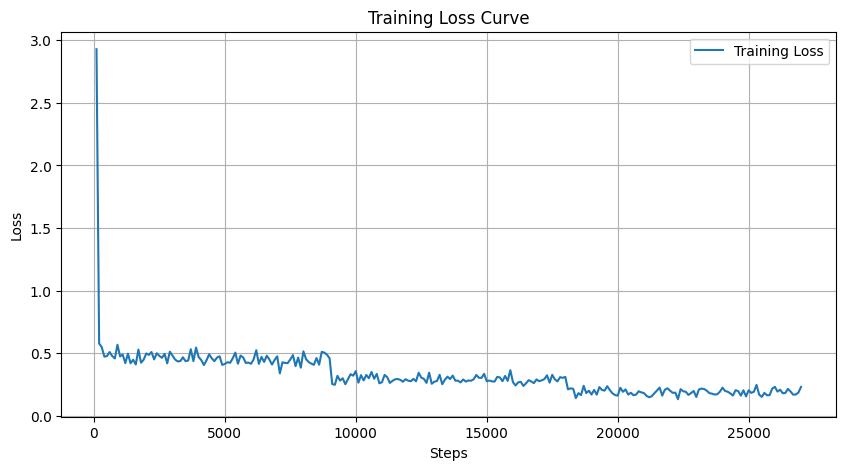

In [ ]:
import matplotlib.pyplot as plt

# Access loss history from trainer
loss_history = trainer.state.log_history

# Extract values
steps = [entry["step"] for entry in loss_history if "loss" in entry]
losses = [entry["loss"] for entry in loss_history if "loss" in entry]

# Plot
plt.figure(figsize=(10,5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.legend()
plt.savefig("training_loss_curve.png")
plt.show()


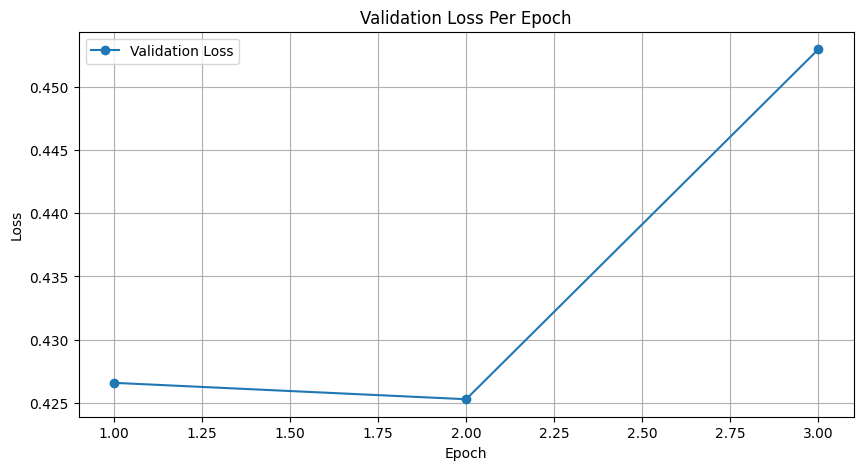

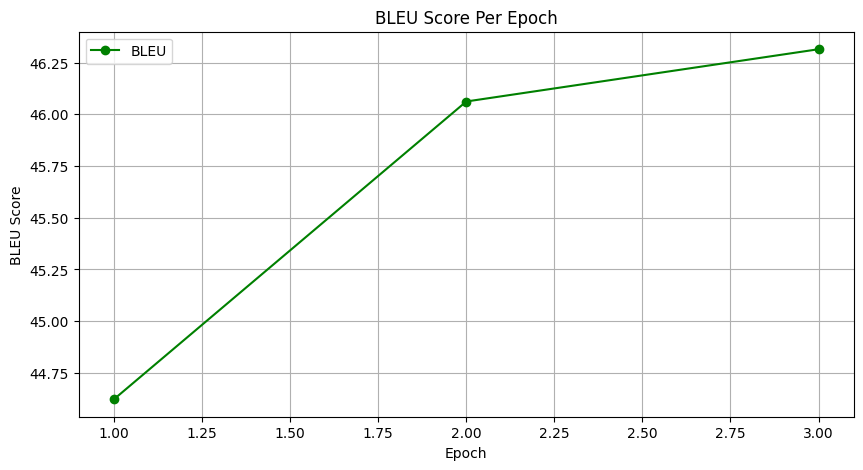

In [ ]:
# Extract epoch metrics
epochs = [entry["epoch"] for entry in loss_history if "eval_loss" in entry]
val_loss = [entry["eval_loss"] for entry in loss_history if "eval_loss" in entry]
bleu_score = [entry["eval_bleu"] for entry in loss_history if "eval_bleu" in entry]

# Plot validation loss
plt.figure(figsize=(10,5))
plt.plot(epochs, val_loss, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Per Epoch")
plt.grid()
plt.legend()
plt.savefig("val_loss_per_epoch.png")
plt.show()

# Plot BLEU
plt.figure(figsize=(10,5))
plt.plot(epochs, bleu_score, marker='o', color='green', label="BLEU")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.title("BLEU Score Per Epoch")
plt.grid()
plt.legend()
plt.savefig("bleu_per_epoch.png")
plt.show()


In [ ]:
!mv training_loss_curve.png /content/drive/MyDrive/ELEC\ 825
!mv val_loss_per_epoch.png /content/drive/MyDrive/ELEC\ 825
!mv bleu_per_epoch.png /content/drive/MyDrive/ELEC\ 825

mv: cannot stat 'val_loss_per_epoch.png': No such file or directory
mv: cannot stat 'bleu_per_epoch.png': No such file or directory


Load model for inference

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

model_path = "./mbart_en_to_fr"

model = MBartForConditionalGeneration.from_pretrained(model_path)
tokenizer = MBart50TokenizerFast.from_pretrained(model_path)

tokenizer.src_lang = "en_XX"
tokenizer.tgt_lang = "fr_XX"


Generate some sample translations

In [ ]:
def translate_text(texts, model, tokenizer):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    generated_ids = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["fr_XX"])
    return tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

# eg
english_texts = [
    "The weather is nice today.",
    "She studied computer science at university.",
    "Artificial intelligence is changing the world.",
    "Canada has two official languages.",
    "We are building a machine translation model."
]

french_translations = translate_text(english_texts, model, tokenizer)

for en, fr in zip(english_texts, french_translations):
    print(f"EN: {en}\nFR: {fr}\n")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


EN: The weather is nice today.
FR: Le temps est beau aujourd'hui.

EN: She studied computer science at university.
FR: Elle a étudié l'informatique à l'université.

EN: Artificial intelligence is changing the world.
FR: L'intelligence artificielle est en train de changer le monde.

EN: Canada has two official languages.
FR: Le Canada dispose de deux langues officielles.

EN: We are building a machine translation model.
FR: Nous construisons un modèle de traduction automatique.



 Save to Drive

In [ ]:
# Compress folder
!zip -r mbart_en_to_fr.zip ./mbart_en_to_fr

!mv mbart_en_to_fr.zip /content/drive/MyDrive/


  adding: mbart_en_to_fr/ (stored 0%)
  adding: mbart_en_to_fr/config.json (deflated 59%)
  adding: mbart_en_to_fr/tokenizer_config.json (deflated 92%)
  adding: mbart_en_to_fr/training_args.bin (deflated 52%)
  adding: mbart_en_to_fr/generation_config.json (deflated 40%)
  adding: mbart_en_to_fr/special_tokens_map.json (deflated 61%)
  adding: mbart_en_to_fr/tokenizer.json (deflated 76%)
  adding: mbart_en_to_fr/model.safetensors (deflated 7%)
  adding: mbart_en_to_fr/sentencepiece.bpe.model (deflated 49%)


Evaluate on WMT14

In [ ]:
from datasets import load_dataset
import sacrebleu

# Reload WMT14 and sample 100 test pairs
wmt14 = load_dataset("wmt14", "fr-en", split="test")
test_subset = wmt14.shuffle(seed=42).select(range(100))

# Extract English and French
en_sentences = [x["translation"]["en"] for x in test_subset]
fr_references = [x["translation"]["fr"] for x in test_subset]

# Translate
def generate_fr_fast(en_texts, model, tokenizer, batch_size=8):
    all_outputs = []
    for i in range(0, len(en_texts), batch_size):
        batch = en_texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(model.device)
        outputs = model.generate(
            **inputs,
            max_length=128,
            num_beams=1,
            early_stopping=True,
            forced_bos_token_id=tokenizer.lang_code_to_id["fr_XX"]
        )
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        all_outputs.extend(decoded)
    return all_outputs

# Run translation
predictions = generate_fr_fast(en_sentences, model, tokenizer)

# Compute BLEU
bleu = sacrebleu.corpus_bleu(predictions, [fr_references])
print(f"\033[1mBLEU score on 100 WMT14 examples:\033[0m {bleu.score:.2f}\n")

# Print a few predictions
for i in range(5):
    print(f"\033[94mENGLISH:\033[0m {en_sentences[i]}")
    print(f"\033[92mPREDICTED FR:\033[0m {predictions[i]}")
    print(f"\033[91mREFERENCE FR:\033[0m {fr_references[i]}")
    print("=" * 80)


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


BLEU score on 100 WMT14 examples: 35.11

ENGLISH: And, most recently, it cannot excuse the failure to design a simple website more than three years since the Affordable Care Act was signed into law.
PREDICTED FR: Et, plus récemment, cela ne peut pas mentérer l'échec de la conception d'un simple site Web depuis plus de trois ans depuis la signature de la loi Affordable Care Act.
REFERENCE FR: Et, plus récemment, elle ne peut pas excuser l'impossibilité de concevoir un simple site Internet pendant plus de trois années après que la loi sur l'Affordable Care Act a été ratifiée.
ENGLISH: Once the Court has declared it admissible, it will proceed to the second stage, the preliminary hearings.
PREDICTED FR: Une fois que le Tribunal l'a déclaré recevable, il passera à la deuxième étape, les audiences préliminaires.
REFERENCE FR: Une fois la recevabilité admise par la Cour, on procède à la deuxième étape, soit les auditions sur le fond.
ENGLISH: The bikes were jostling to get in front and take 

In [ ]:
import pandas as pd

df_eval = pd.DataFrame({
    "English": en_sentences,
    "Predicted French": predictions,
    "Reference French": fr_references
})

# Save to CSV
df_eval.to_csv("mbart_wmt14_eval_100.csv", index=False)

!cp mbart_wmt14_eval_100.csv /content/drive/MyDrive/ELEC\ 825


In [ ]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

model_path = "/content/mbart_en_to_fr"

tokenizer = MBart50TokenizerFast.from_pretrained(model_path)
model = MBartForConditionalGeneration.from_pretrained(model_path).to("cuda")
tokenizer.src_lang = "en_XX"



Evaluating on a Larger Sample

In [ ]:
# Load 1000 WMT14 samples
test_subset_1000 = test_data.shuffle(seed=42).select(range(1000))
en_sentences_1000 = [x["translation"]["en"] for x in test_subset_1000]
fr_references_1000 = [x["translation"]["fr"] for x in test_subset_1000]

# Translate
predictions_1000 = generate_fr_fast(en_sentences_1000, model, tokenizer, batch_size=16)

# Compute BLEU
bleu_1000 = sacrebleu.corpus_bleu(predictions_1000, [fr_references_1000])
print(f"\033[1mBLEU score on 1000 WMT14 examples:\033[0m {bleu_1000.score:.2f}\n")

# Print 10 example translations
for i in range(10):
    print(f"\033[94mENGLISH:\033[0m {en_sentences_1000[i]}")
    print(f"\033[92mPREDICTED FR:\033[0m {predictions_1000[i]}")
    print(f"\033[91mREFERENCE FR:\033[0m {fr_references_1000[i]}")
    print("=" * 80)

#  Save all 1000 results to CSV and move to Drive
import pandas as pd
df_eval_1000 = pd.DataFrame({
    "English": en_sentences_1000,
    "Predicted French": predictions_1000,
    "Reference French": fr_references_1000
})
df_eval_1000.to_csv("mbart_wmt14_eval_1000.csv", index=False)

!cp mbart_wmt14_eval_1000.csv /content/drive/MyDrive/ELEC\ 825


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


BLEU score on 1000 WMT14 examples: 34.66

ENGLISH: And, most recently, it cannot excuse the failure to design a simple website more than three years since the Affordable Care Act was signed into law.
PREDICTED FR: Et, plus récemment, cela ne peut pas mentérer l'échec de la conception d'un simple site Web depuis plus de trois ans depuis la signature de la loi Affordable Care Act.
REFERENCE FR: Et, plus récemment, elle ne peut pas excuser l'impossibilité de concevoir un simple site Internet pendant plus de trois années après que la loi sur l'Affordable Care Act a été ratifiée.
ENGLISH: Once the Court has declared it admissible, it will proceed to the second stage, the preliminary hearings.
PREDICTED FR: Une fois que le Tribunal l'a déclaré recevable, il passera à la deuxième étape, les audiences préliminaires.
REFERENCE FR: Une fois la recevabilité admise par la Cour, on procède à la deuxième étape, soit les auditions sur le fond.
ENGLISH: The bikes were jostling to get in front and take